# 实验三：参数估计 & 非参数估计

## 实验要求
### 截止日期：11月3日
作业的提交格式参考之前的说明，提交到18329300691@163.com
### 基本要求
生成两个各包含 N=1000 个二维随机向量的数据集合 $X_1$ 和 $X_2$，数据集合中随机向量来自于三个分布模型，分别满足均值向量 $\mu_1=[1,4]$,$\mu_2=[4,1]$, $\mu_3=[8,4]$ 和协方差矩阵 $D_1=D_2=D_3=2\pmb{I}$ ，其中$\pmb{I}$是 $2*2$的单位矩阵。在生成数据集合 $X_1$ 时，假设来自三个分布模型的先验概率相同 ；而在生成数据集合 $X_2$ 时，先验概率如下：$p(w_1)=0.6$, $p(w_2)=0.3$, $p(w_3)=0.1$


在两个数据集合上分别应用“似然率测试规则” 和“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。


### 中级要求
在两个数据集合上使⽤⾼斯核函数估计⽅法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1,
1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果

### 高级要求
在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析 $k=1，3，5$ 时的概率密度估计结果

In [21]:
# 导入库和必要的包
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from sklearn.model_selection import KFold
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree

In [33]:
# Generate Dataset
N = 1000
mu1 = np.array([1, 4])
mu2 = np.array([4, 1])
mu3 = np.array([8, 4])
D = 2 * np.eye(2)
prior_X1 = [1/3, 1/3, 1/3]
prior_X2 = [0.6, 0.3, 0.1]

samples_X1_w1 = np.random.multivariate_normal(mu1, D, int(N * prior_X1[0]))
samples_X1_w2 = np.random.multivariate_normal(mu2, D, int(N * prior_X1[1]))
samples_X1_w3 = np.random.multivariate_normal(mu3, D, int(N * prior_X1[2])+1)

samples_X2_w1 = np.random.multivariate_normal(mu1, D, int(N * prior_X2[0]))
samples_X2_w2 = np.random.multivariate_normal(mu2, D, int(N * prior_X2[1]))
samples_X2_w3 = np.random.multivariate_normal(mu3, D, int(N * prior_X2[2]))

X1 = np.vstack((samples_X1_w1, samples_X1_w2, samples_X1_w3))
X2 = np.vstack((samples_X2_w1, samples_X2_w2, samples_X2_w3))

labels_X1 = np.array([1] * len(samples_X1_w1) + [2] * len(samples_X1_w2) + [3] * len(samples_X1_w3))
labels_X2 = np.array([1] * len(samples_X2_w1) + [2] * len(samples_X2_w2) + [3] * len(samples_X2_w3))

X1.shape, X2.shape, labels_X1.shape, labels_X2.shape


((1000, 2), (1000, 2), (1000,), (1000,))

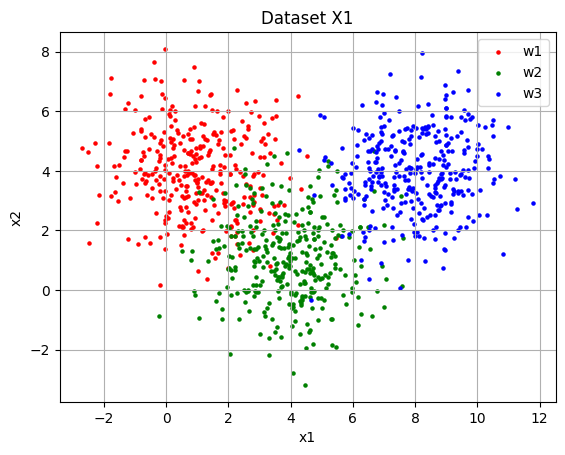

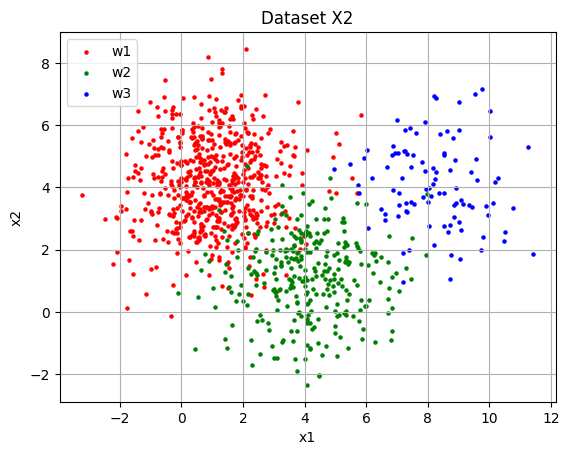

In [23]:
# 展示数据分布

def plot_dataset(samples, title):
    colors = ['red', 'green', 'blue']
    labels = ['w1', 'w2', 'w3']
    for i, sample in enumerate(samples):
        plt.scatter(sample[:, 0], sample[:, 1], color=colors[i], label=labels[i], s=5)
    plt.legend()
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    plt.show()

plot_dataset([samples_X1_w1, samples_X1_w2, samples_X1_w3], 'Dataset X1')

plot_dataset([samples_X2_w1, samples_X2_w2, samples_X2_w3], 'Dataset X2')


# 基础知识——参数估计

在开始下面的内容前，我们首先考虑一些基础知识与内容，首先我们需要考虑的是motivation，也就是说我们为什么要进行参数估计。目前我们有一些数据，首先我们确信该数据服从某种特定的数据分布，那既然我们已知该数据的分布特性，例如某些数据服从于高斯分布，那么下一个问题是，如果我想要拟合出这种数据分布，我们就需要知道高斯分布的均值和方差。那么我们的动机就很清晰了，参数分布事实上需要做的事情是**是在已知数据服从某种分布时，根据采样得到的样本(数据集)求分布的参数**。


首先，我们考虑先验和后验的定义，这两者在概率论与机器学习中用处十分广泛：

- 先验概率：我们在考虑任何新的观测数据之前对不确定性的主观判断，或者换言之，是根据先前的实验中得到的概率。

- 后验概率：是在观测到新数据或证据后，我们对同一个不确定量的更新后的信仰或概率。它结合了先验概率和新的观测数据来得出一个修正后的概率。

事实上，使用贝叶斯定理，或者叫做条件概率，后验概率可以计算为：

$$
P(\theta | X) = \frac{P(X | \theta) \times P(\theta)}{P(X)}
$$

其中：
- $ P(\theta | X) $ 是后验概率。
- $ P(X | \theta) $ 是给定参数 $ \theta $ 时数据 $ X $ 的似然。
- $ P(\theta) $ 是先验概率。
- $ P(X) $ 是数据的边际概率，它可以看作是对所有可能的 $ \theta $ 值进行积分或求和的似然和先验的乘积。

可能对于似然的理解会有些困惑，在这里我们详细说明似然的相关定义。似然与概率的定义相似但不同，当我们考虑概率时，事实上我们是在考虑给定一定参数时，某组数据出现的可能性；而似然则是考虑我们固定了一组数据，考虑其在不同参数下出现的可能。或者换言之，概率指的是在给定参数的情况下，某种数据出现的可能性，而似然则是在给定样本的前提下，考虑某种参数对样本数据的支持度。

那么我们对上面的后验概率计算公式给出一个更加详细的说明：我们考虑条件概率的公式：

$$
P(A|B)=\frac{P(AB)}{P(B)}=\frac{P(B|A) \times P(A)}{P(B)}
$$

我们发现贝叶斯定理和条件概率的计算公式惊人的相似，这与我们上面讨论过的概率与似然的区别相关，我们上面说过，概率是参数对数据的可能，我们求概率时需要用条件概率；那么似然是数据对参数的支撑度，我们求似然时就需要用到贝叶斯定义。那么我们所寻求的后验概率$ P(\theta | X) $，事实上就是在观测到数据$X$时，有多大的可能参数取到$θ$；那么我们上述的讨论，事实上就将贝叶斯定理，或者换言之后验概率，与条件概率画上了等号。

### 总结

- **先验概率**是我们在观测到新数据之前的信仰或概率。
- **后验概率**是在观测到新数据后的更新信仰或概率。


# 参数估计方法

在考虑完上面的一些基础知识后，我们就可以考量如何进行参数估计，我们在下面将给出三种参数估计方法，分别是最大似然估计，最大后验概率估计以及贝叶斯估计。

## 最大似然估计(MLE)

我们在上面提到：我们在计算后验概率时需要先验概率作为前置知识，但有些时候，我们只能对环境采样，得到一系列样本，而无法得到一些先验知识，那么在这种情况下，我们考虑如何对样本的参数进行有效的估计：我们可以考虑最大化似然。

我们在上面提到，似然是指在观测到给定数据时，某种参数出现的可能性，那么我们在估计参数时，就可以考虑取似然最大的那种参数，或者换言之，我们假设样本$X$有参数$\theta$，我们想要寻求$\hat \theta$，使得对于$∀x \in X$，我们有$P(\hat \theta |x) = max(P(\theta_1|x),P(\theta_2|x),...,P(\theta_m|x))$成立。这样肯定是最优的，因为这样选取的$\theta$，其每一个样本都在支持他选择这组参数，但是往往不同的观测值可能会支持不同的参数值。这使得基于单个观测值的后验概率来选择整体参数变得困难。并且由于每个观测值可能支持不同的参数，我们没有一个明确的方式来汇总这些信息并得到一个整体的参数估计。单个观测值可能受到噪声、异常值或其他偶然因素的影响。基于单个观测值的后验概率可能会导致过度敏感和不稳定的参数估计。当然，我们完全可以设计一个全新的方法对后验概率进行统计，定义全新的方法统计每一个样本得到的支持参数值，这种方法我们考虑后续实现并对比已有的方法。

因此，通常更合适的做法是考虑整体数据的似然函数，而不是每个独立观测值的后验概率。我们接下来从另一个维度考虑这件事情：我们考虑$X_1,X_2...X_n$是来自总体$X$的一组样本，其取值分别为$x_1,x_2...x_n$，那么对于参数$\theta$，其概率分布为$P(X_1,X_2...X_n;\theta)=\Pi_{i∈[1,n]} p(X_i,\theta)$。那么从另一个角度考虑，我们可以将上面的联合分布考虑为，在观测样本为$x_1,x_2...x_n$且参数为$\theta$时，事件发生的概率，当我们将$x_1,x_2...x_n$视为常量时，该方程可视为一个一元方程，即：$L(\theta)=\Pi_{i∈[1,n]}p(X_i,\theta)$，那么从这个角度来看，我们构建了一个似然方程，该方程的不同$\theta$取值，代表着相同样本下，参数的不同取值的可能性，那么我们很自然的就引出一个想法，我们取的参数值为似然函数的最大值，那么是不是我们参数估计的误差就会很低，因为参数是该值的可能性是最大的。那么我们的目的就转变为了求似然函数的最大值：那么我们就可以对似然函数求偏导，得到似然方程组，解该方程组，即可得到最终的结果。


## 最大后验概率估计(MAP)

最大后验概率估计是贝叶斯统计中的一种参数估计方法。与最大似然估计（MLE）相似，MAP估计法旨在找到使某种函数最大化的参数值。但不同于MLE只关心数据的似然，MAP同时考虑先验信息和数据似然。

MAP估计的定义如下：

$$
\hat{\theta}_{MAP} = \arg\max_{\theta} P(\theta | X)
$$

其中 $ \theta $ 是我们要估计的参数，$ X $ 是观测到的数据。

使用贝叶斯定理，上述表达式可以重写为：

$$
\hat{\theta}_{MAP} = \arg\max_{\theta} \frac{P(X | \theta) \times P(\theta)}{P(X)}
$$

注意到分母 $ P(X) $ 是关于 $ \theta $ 的常数，因此在优化过程中可以忽略。因此，MAP估计可以简化为：

$$
\hat{\theta}_{MAP} = \arg\max_{\theta} P(X | \theta) \times P(\theta)
$$

这里:
- $ P(X | \theta) $ 是似然。它表示在给定参数 $ \theta $ 时，观测到数据 $ X $ 的概率。
- $ P(\theta) $ 是先验概率。它表示在观测到任何数据之前对 $ \theta $ 的信仰或概率。


MAP估计结合了先验信息和数据似然来估计参数。当我们没有考虑先验知识时，尤其在样本量较少的情况下，我们可能会得到与实际情况（先验知识）不符的估计结果。其可能导致模型只考虑了当前异常的数据，没有考虑到本来的特征(先验)导致过拟合。而当先验信息很弱或非常均匀时，MAP估计接近MLE。总的来说，最大后验概率估计提供了一种结合先验信息和数据似然来估计参数的方法。它特别适用于当我们对参数有一些先验知识的情况。


## 贝叶斯估计


贝叶斯估计是一种参数估计方法，它基于贝叶斯定理。与最大似然估计（MLE）和最大后验概率估计（MAP）不同，贝叶斯估计不仅提供参数的点估计，还提供参数的完整后验分布。

贝叶斯估计的核心思想是结合先验概率和数据似然来获得参数的后验概率分布。这个后验分布可以告诉我们关于参数的很多信息，包括它的期望值、方差以及其他统计特性。我们在上面提过，贝叶斯公式为：

$$
P(\theta | X) = \frac{P(X | \theta) \times P(\theta)}{P(X)}
$$

其中：
- $ P(\theta | X) $ 是后验概率分布，表示在观测到数据 $ X $ 后参数 $ \theta $ 的概率分布。
- $ P(X | \theta) $ 是似然，表示给定参数 $ \theta $ 时数据 $ X $ 的概率。
- $ P(\theta) $ 是先验分布，表示在观测到数据之前对参数 $ \theta $ 的信仰或概率。
- $ P(X) $ 是边际概率，表示在所有可能的 $ \theta $ 值下观测到数据 $ X $ 的概率。


我们可以发现，贝叶斯估计不像MLE或MAP只给出点估计，其提供了参数的完整后验分布。允许我们结合先验知识和观测数据来估计参数。当有新数据可用时，我们可以简单地更新后验分布，而无需从头开始。

但与此同时，计算后验分布可能在计算上非常复杂，尤其是在高维参数空间中。需要选择一个先验分布，这可能会影响后验分布。虽然有些先验（如共轭先验）可以简化计算，但选择合适的先验仍然是一个挑战。对于复杂的模型，计算后验分布可能需要高级的采样技术，如MCMC（Markov Chain Monte Carlo）。

我们在这里给出一个一般性的技术路线以实现贝叶斯估计：

贝叶斯估计的计算过程涉及到从后验概率分布中得到参数的估计。具体的计算过程可能因问题的性质和所用的方法而异，但通常的步骤如下：

1. **选择先验分布** $ P(\theta) $：
   - 先验可以是非信息性的，例如均匀分布，这样的先验不对参数估计施加任何特定的信仰。
   - 先验也可以是信息性的，基于以前的研究或领域知识。
   - 在某些情况下，我们可以选择共轭先验，这样的先验可以简化后验分布的计算。

2. **计算似然** $ P(X | \theta) $：
   - 这是给定参数 $ \theta $ 时，观测到数据 $ X $ 的概率。
   - 通常，这是根据我们的统计模型直接计算的。

3. **计算后验分布** $ P(\theta | X) $：
   - 使用贝叶斯公式，结合先验和似然来计算后验概率。
   - $ P(\theta | X) \propto P(X | \theta) \times P(\theta)$
   - 注意：在很多情况下，直接计算后验分布可能是困难的，特别是当它涉及到多个参数或复杂的模型时。

4. **从后验分布中得到参数的估计**：
   - **点估计**：可以使用后验分布的模式（最大后验估计，MAP），均值或中位数作为参数的点估计。
   - **区间估计**：可以使用后验分布的百分位数来得到参数的置信区间。

5. **（可选）后验预测**：
   - 使用后验分布来预测新的观测值。

6. **（如果有新数据）更新后验分布**：
   - 如果有新的数据可用，我们可以使用当前的后验分布作为新的先验，然后重复上述过程。

# 基础要求

那么接下来，我们将实现基础要求：在两个数据集合上分别应用“似然率测试规则” 和“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。我们还是首先介绍一下这两个规则：

## 似然率测试规则

似然率测试规则是一种决策规则，常用于统计假设检验和模式识别中。它基于似然率（likelihood ratio）来决定一个观测数据更可能属于哪一个类或哪一个假设更可能为真。

### 1. 似然率定义

似然率是两个似然函数的比值。假设我们有两个假设或类别 $ w_1 $ 和 $ w_2 $，对于观测数据 $ x $，其似然率定义为：

$$
\Lambda(x) = \frac{p(x|w_1)}{p(x|w_2)}
$$

这里，$ p(x|w_1) $ 是在假设或类别 $ w_1 $ 下，观测数据 $ x $ 的似然；而 $ p(x|w_2) $ 是在 $ w_2 $ 下的似然。

### 2. 似然率测试规则

为了基于似然率决策，我们会选择一个阈值 $ \lambda $。然后，决策过程如下：

- 如果 $ \Lambda(x) > \lambda $，则选择假设或类别 $ w_1 $。
- 如果 $ \Lambda(x) \leq \lambda $，则选择假设或类别 $ w_2 $。

这个阈值 $ \lambda $ 可以基于一些标准来选择，例如最小化错误率或考虑到决策的成本和收益。

### 3. 问题

但问题是，这种决策手段只适用于二分类问题，或者换言之，只能判断数据属于某两个类别，在我们本次实验中，数据是来自三个数据分布，那么在这里，我们采取一个全新的决策策略进行判断：

对于给定的观测数据 $x$ 和一组均值向量 $mus$，然后我们计算每个均值向量（或类别）对应的似然函数值。然后，选择似然值最大的类别作为分类结果。这种决策便类似于最大似然估计的决策手段，我们只考虑当前的数据分布，然后通过计算似然函数的值来进行决策。

## 最大后验概率规则

最大后验概率规则（MAP规则），与上面我们讨论的似然率决策同为决策理论中的一种方法，常用于模式识别和统计决策问题。与似然率测试规则不同，MAP规则基于后验概率来做决策。

### 1. 最大后验概率规则的定义

对于观测数据 $ x $ 和假设或类别集合 $ \{w_1, w_2, \ldots, w_k\} $，MAP规则选择那个给定数据 $ x $ 的后验概率最大的假设或类别：

$$
\hat{w} = \arg\max_{w_i} P(w_i | x)
$$

这里，$ P(w_i | x) $ 是给定观测数据 $ x $ 时假设或类别 $ w_i $ 的后验概率。

### 2. 基于贝叶斯公式的后验概率

使用贝叶斯公式，后验概率可以表示为：

$$
P(w_i | x) = \frac{p(x | w_i) \times P(w_i)}{p(x)}
$$

其中：
- $ p(x | w_i) $ 是在假设或类别 $ w_i $ 下，观测数据 $ x $ 的似然。
- $ P(w_i) $ 是假设或类别 $ w_i $ 的先验概率。
- $ p(x) $ 是观测数据 $ x $ 的边际概率。

### 3. 决策规则

对于给定的观测数据$x$、一组均值向量 $mus$ 和对应的先验概率 $priors$，我们首先计算每个类别的似然函数值。然后，将每个类别的似然乘以对应的先验概率，得到后验概率(忽略分母的常量，因为我们要取相对大小)。最后，选择后验概率最大的类别作为分类结果。

由于我们不能调用库函数，那么我们需要自行实现计算对应似然函数以及计算后验概率的函数。我们需要考虑多变量正态分布的概率密度函数(pdf)公式。多元正态分布的pdf公式为：

$$
p(x|\mu, \Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}} \exp\left(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)\right)
$$

其中:
- $ x $ 是观测向量。
- $ \mu $ 是均值向量。
- $ \Sigma $ 是协方差矩阵。
- $ n $ 是向量的维度。


In [6]:
def multivariate_normal_pdf(x, mean, cov):
    n = len(x)
    diff = x - mean
    return (1.0 / (2 * np.pi)**(n/2) / np.sqrt(det(cov))) * np.exp(-0.5 * diff.T @ inv(cov) @ diff)

def posterior_custom(x, mu, D, prior):
    return multivariate_normal_pdf(x, mu, D) * prior

In [7]:
# 计算似然函数
def likelihood(x, mu, D):
    return multivariate_normal_pdf(x, mean=mu, cov=D)

# 后验概率函数
def posterior(x, mu, D, prior):
    return likelihood(x, mu, D) * prior

# 似然率决策规则(使用似然函数的值决策)
def classify_likelihood(x, mus, D):
    likelihoods = [likelihood(x, mu, D) for mu in mus]
    return np.argmax(likelihoods) + 1

# 最大后验概率规则(使用后验概率决策)
def classify_map(x, mus, D, priors):
    posteriors = [posterior_custom(x, mu, D, prior) for mu, prior in zip(mus, priors)]
    return np.argmax(posteriors) + 1

def classification_error_rate(X, true_labels, classify_fn, *args):
    predicted_labels = np.array([classify_fn(x, *args) for x in X])
    incorrect = np.sum(predicted_labels != true_labels)
    return incorrect / len(true_labels)

mus = [mu1, mu2, mu3]

error_rate_X1_likelihood = classification_error_rate(X1, labels_X1, classify_likelihood, mus, D)
error_rate_X1_map = classification_error_rate(X1, labels_X1, classify_map, mus, D, prior_X1)

error_rate_X2_likelihood = classification_error_rate(X2, labels_X2, classify_likelihood, mus, D)
error_rate_X2_map = classification_error_rate(X2, labels_X2, classify_map, mus, D, prior_X2)

error_rate_X1_likelihood, error_rate_X1_map, error_rate_X2_likelihood, error_rate_X2_map


(0.057, 0.057, 0.075, 0.068)

基于似然率测试规则和最大后验概率规则，我们得到以下分类错误率：

- 对于数据集$X_1$使用似然率测试规则的错误率：约为5.7%；使用最大后验概率规则的错误率：约为5.7%

- 对于数据集$X_2$使用似然率测试规则的错误率：约为7.5%；使用最大后验概率规则的错误率：约为6.8%


对于数据集$X_1$由于三个类的先验概率相同，因此似然率测试规则和最大后验概率规则得到相同的错误率；而对于数据集$X_2$，最大后验概率规则的错误率略低于似然率测试规则。这是因为我们先验概率不同，最大后验概率规则考虑了这些差异，从而获得了更好的分类结果。

# 中级要求

接下来我们实现中级要求的相关内容：在两个数据集合上使⽤⾼斯核函数估计⽅法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1,
1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果。与上面类似的，我们先来考虑高斯核函数估计方法的背景知识，

### 1. 核密度估计（Kernel Density Estimation, KDE）

高斯核函数估计（也被称为核密度估计，特别是当使用高斯核时）是一种无参数方法，用于估计一个随机变量的概率密度函数。它特别适用于当我们没有关于数据分布的先验知识时。以下是高斯核函数估计的详细介绍：

核密度估计是一种方法，它使用一组已知的数据点和一个核函数来估计任意位置的概率密度。数学上，KDE的公式为：

$$
\hat{f}(x) = \frac{1}{nh} \sum_{i=1}^{n} K\left(\frac{x - x_i}{h}\right)
$$

其中：
- $ n $ 是数据点的数量。
- $ \hat{f}(x)$是在位置$x$(样本空间的某点，可以是向量)上估计出来的概率密度值
- $ x_i $ 是第 $ i $ 个数据点。
- $ K $ 是核函数。
- $ h $ 是一个称为带宽的正参数，它决定了估计的平滑程度。

也就是说，我们通过上面的公式，可以计算出原来样本在其值空间内任意一点的概率密度，进而我们可以通过此对整体的分布有更清晰的了解

### 2. 高斯核函数

高斯核函数是KDE中常用的一个核函数。它的公式为：

$$
K(u) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} u^2}
$$

这实际上就是标准正态分布的概率密度函数，这也就是为什么我们将其称之为高斯核函数。

### 3. 为什么使用高斯核？

那么下一个问题就是，我们使用其有什么好处？高斯核有很多优点：
- 它是无限支持的，意味着它可以为所有的输入 $ x $ 产生非零的输出。
- 它是平滑的，所以估计的概率密度函数也会是平滑的。
- 在实际中，很多真实数据的分布接近于正态分布，因此高斯核经常能提供良好的估计。

### 4. 带宽的选择

带宽 $ h $ 是KDE中的一个关键参数，它决定了估计的平滑程度：
- 如果 $ h $ 太小，估计会过于嘈杂，并可能过拟合数据。
- 如果 $ h $ 太大，估计会过于平滑，并可能忽略数据中的重要结构。

通常，选择合适的带宽需要一些实验和交叉验证。那么$h$更加类似于一个窗口，类似于我们对于回归过程选点拟合，我们如果选点过多，可能就导致过于嘈杂，导致了过拟合(原本是一个sinx，我们却拟合出来很多的噪声波峰)，如果选点过少，可能是一条直线，$h$也是同样的道理

### 5. KDE的应用

核密度估计有许多应用，包括但不限于：
- 数据可视化：估计并绘制数据的概率密度函数。
- 异常检测：如果一个点在估计的概率密度函数上的值很低，那么它可能是一个异常点。
- 模式识别：使用KDE来估计并分类数据。

总的来说，高斯核函数估计是一种强大的非参数方法，用于估计数据的概率密度函数，特别是当我们没有关于数据分布的先验知识时。那么接下来我们将实现这一点。

### 6. 决策依据

似然率测试规则:

- 使用高斯核函数估计方法来估计每个类别的概率密度函数 (PDF)。
- 对于给定的输入$x$，使用高斯核函数估计方法计算该输入属于每个类别的似然度。
- 分类为似然度最大的类别。

最大后验概率规则:

- 同样地，首先使用高斯核函数估计方法来估计每个类别的 PDF。
- 对于给定的输入$x$，计算其属于每个类别的后验概率，这是似然度与该类别的先验概率的乘积。
- 分类为后验概率最大的类别。

也就是说，与之前的方法比，主要差别在于我们计算似然函数的方式出现了变化，原本是根据我们使用假设的分布（例如高斯分布）来计算似然度。而现在，我们使用核函数估计方法来估计似然度。也就是说，用核函数拟合出来的PDF替代了原本的PDF。

In [13]:
def custom_k_fold(X, K=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_size = len(indices) // K

    splits = []
    for k in range(K):
        test_indices = folds[k]
        train_indices = np.delete(indices, np.s_[k*fold_size : (k+1)*fold_size])
        splits.append((train_indices, test_indices))

    return splits

def cdist_custom(XA, XB):
    distances = np.empty((XA.shape[0], XB.shape[0]))
    for i in range(XA.shape[0]):
        for j in range(XB.shape[0]):
            distances[i, j] = np.sqrt(np.sum((XA[i] - XB[j])**2))
    return distances

In [24]:
# 高斯核函数
def gaussian_kernel(x, X, h):
    distances = cdist_custom(x.reshape(1, -1), X).flatten()
    return np.exp(-distances**2 / (2 * h**2))

# 计算KDE
def kde(x, X, h):
    N = len(X)
    return np.sum(gaussian_kernel(x, X, h)) / (N * h**2)

# 使用似然与KDE估计
def classify_likelihood_kde(x, datasets, h):
    likelihoods = [kde(x, dataset, h) for dataset in datasets]
    return np.argmax(likelihoods) + 1

# 使用最大MAP(最大后验概率)与KDE
def classify_map_kde(x, datasets, h, priors):
    posteriors = [kde(x, dataset, h) * prior for dataset, prior in zip(datasets, priors)]
    return np.argmax(posteriors) + 1

# 交叉验证
h_values = [0.1, 0.5, 1, 1.5, 2]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 计算误差
def cross_val_error_rate(X, labels, classify_fn, datasets, h_values, priors=None):
    avg_errors = []
    for h in h_values:
        fold_errors = []
        for train_index, test_index in custom_k_fold(X):
            if priors:
                fold_error = classification_error_rate(X[test_index], labels[test_index], classify_fn, datasets, h, priors)
            else:
                fold_error = classification_error_rate(X[test_index], labels[test_index], classify_fn, datasets, h)
            fold_errors.append(fold_error)
        avg_errors.append(np.mean(fold_errors))
    return avg_errors

datasets_X1 = [samples_X1_w1, samples_X1_w2, samples_X1_w3]
datasets_X2 = [samples_X2_w1, samples_X2_w2, samples_X2_w3]

cv_error_X1_likelihood_kde = cross_val_error_rate(X1, labels_X1, classify_likelihood_kde, datasets_X1, h_values)
cv_error_X1_map_kde = cross_val_error_rate(X1, labels_X1, classify_map_kde, datasets_X1, h_values, prior_X1)

cv_error_X2_likelihood_kde = cross_val_error_rate(X2, labels_X2, classify_likelihood_kde, datasets_X2, h_values)
cv_error_X2_map_kde = cross_val_error_rate(X2, labels_X2, classify_map_kde, datasets_X2, h_values, prior_X2)

optimal_h_X1_likelihood = h_values[np.argmin(cv_error_X1_likelihood_kde)]
optimal_h_X1_map = h_values[np.argmin(cv_error_X1_map_kde)]
optimal_h_X2_likelihood = h_values[np.argmin(cv_error_X2_likelihood_kde)]
optimal_h_X2_map = h_values[np.argmin(cv_error_X2_map_kde)]

(optimal_h_X1_likelihood, optimal_h_X1_map, optimal_h_X2_likelihood, optimal_h_X2_map), (cv_error_X1_likelihood_kde, cv_error_X1_map_kde, cv_error_X2_likelihood_kde, cv_error_X2_map_kde)


((0.1, 0.1, 0.1, 0.1),
 ([0.016, 0.08, 0.085, 0.08700000000000001, 0.085],
  [0.016, 0.08, 0.085, 0.08700000000000001, 0.085],
  [0.022, 0.05700000000000001, 0.061, 0.061, 0.064],
  [0.009, 0.053000000000000005, 0.061, 0.067, 0.086]))

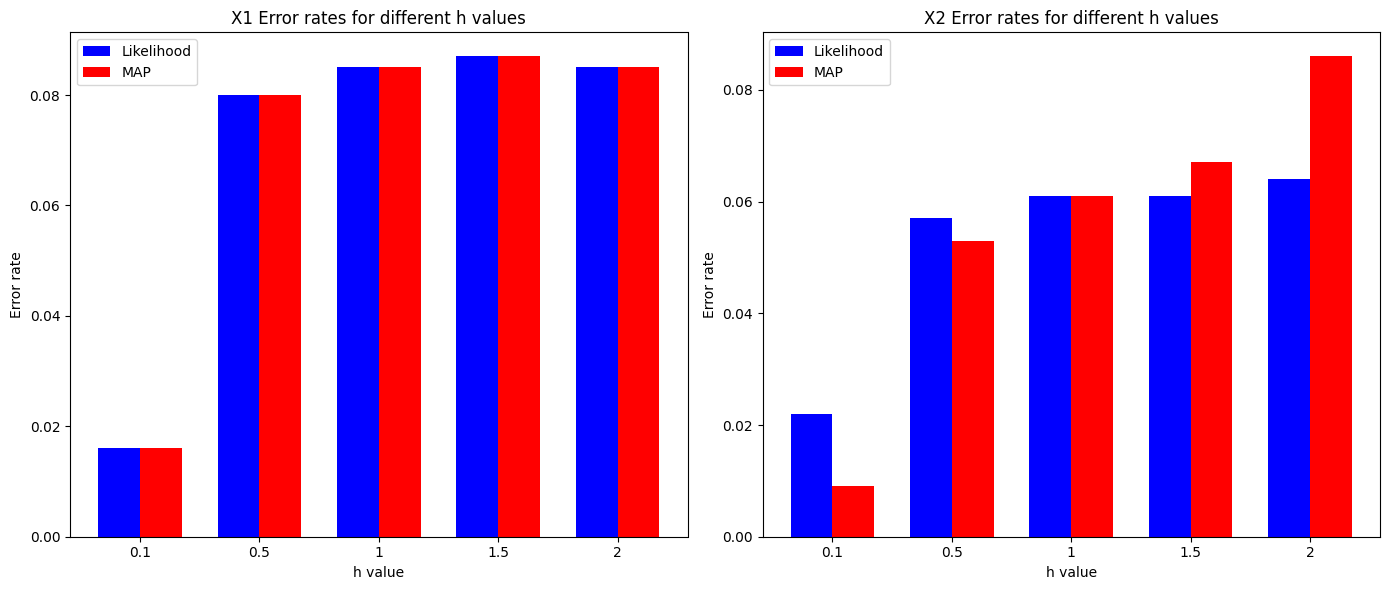

In [25]:
# 柱状图展示误差

# 设置柱状图的宽度
bar_width = 0.35

# 设置柱状图的位置
index = np.arange(len(h_values))

plt.figure(figsize=(14, 6))

# X1 数据集
plt.subplot(1, 2, 1)
bar1 = plt.bar(index, cv_error_X1_likelihood_kde, bar_width, color='b', label='Likelihood')
bar2 = plt.bar(index + bar_width, cv_error_X1_map_kde, bar_width, color='r', label='MAP')
plt.xlabel('h value')
plt.ylabel('Error rate')
plt.title('X1 Error rates for different h values')
plt.xticks(index + bar_width / 2, h_values)  # 显示x轴的标签
plt.legend()

# X2 数据集
plt.subplot(1, 2, 2)
bar1 = plt.bar(index, cv_error_X2_likelihood_kde, bar_width, color='b', label='Likelihood')
bar2 = plt.bar(index + bar_width, cv_error_X2_map_kde, bar_width, color='r', label='MAP')
plt.xlabel('h value')
plt.ylabel('Error rate')
plt.title('X2 Error rates for different h values')
plt.xticks(index + bar_width / 2, h_values)  # 显示x轴的标签
plt.legend()

plt.tight_layout()
plt.show()



- 对于数据集 $X_1$：
  - 似然率测试规则和最大后验概率规则的最佳 $ h $ 值都是 0.1。
  - 对于不同的 $ h $ 值，似然率测试规则的交叉验证误差率分别为 0.016, 0.08, 0.085, 0.087, 0.085。
  - 对于不同的 $ h $ 值，最大后验概率规则的交叉验证误差率与似然率测试规则相同。

- 对于数据集 $X_2$：
  - 似然率测试规则和最大后验概率规则的最佳 $ h $ 值都是 0.1。
  - 对于不同的 $ h $ 值，似然率测试规则的交叉验证误差率分别为 0.022, 0.057, 0.061, 0.061, 0.064。
  - 对于不同的 $ h $ 值，最大后验概率规则的交叉验证误差率分别为 0.009, 0.053, 0.061, 0.067, 0.086。

从这些结果中，我们可以观察到以下几点：

1. **较低的 $ h $ 值更优**：对于两个数据集，当 $ h = 0.1 $ 时，误差率都是最低的。这表明数据可能较为密集，所以较小的宽度参数 $ h $ 能更好地捕获数据的局部结构。

2. **误差率的变化**：当 $ h $ 值从 0.1 增加到 2 时，误差率都有所上升，这意味着较大的 $ h $ 值可能会导致过度平滑，从而导致更高的分类误差。

3. **似然率测试规则与最大后验概率规则的相似性**：对于数据集 $X_1$，这两种规则给出了完全相同的误差率。这可能意味着数据集 $X_1$ 的类别是均匀分布的，或者说先验概率对于这两种规则的影响不大。

结论：
- 数据可能是密集的，因此较小的宽度参数 $ h $ 更适合捕获其局部结构。
- 数据可能具有明确的边界或区分不同类别的特征，因此较小的 $ h $ 值可以提供最佳的分类性能。
- 对于 $X_1$，先验概率可能与数据中观察到的分布相一致，因此似然率测试规则和最大后验概率规则给出了相同的结果。


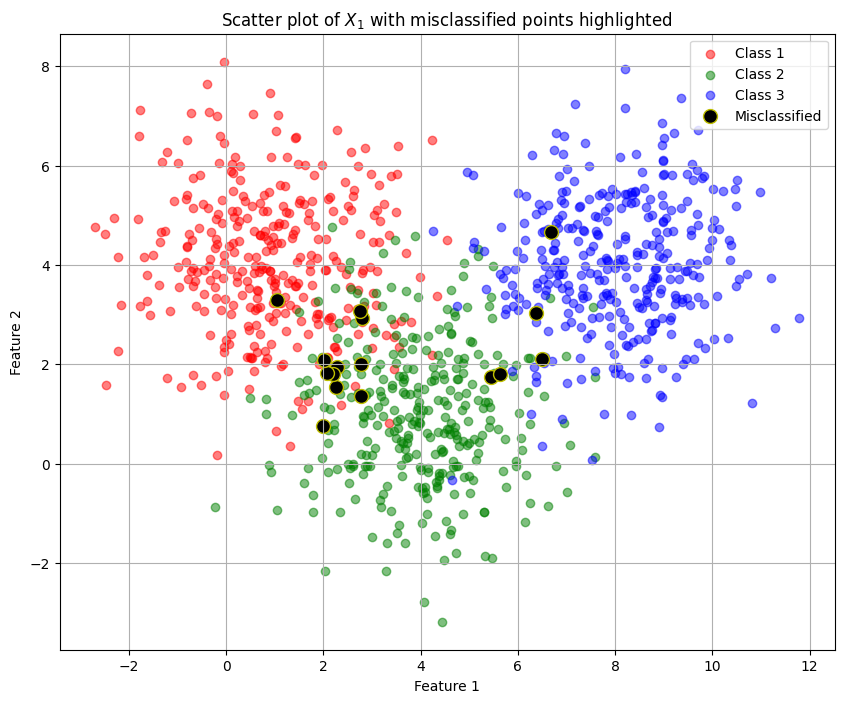

In [26]:
import matplotlib.pyplot as plt

# 使用最佳h值进行分类
predicted_labels_X1 = np.array([classify_map_kde(x, datasets_X1, optimal_h_X1_map, prior_X1) for x in X1])

# 找出分类错误的点
misclassified_indices_X1 = np.where(predicted_labels_X1 != labels_X1)[0]

# 绘制散点图
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b']

# 绘制正确分类的点
for i, dataset in enumerate(datasets_X1, 1):
    plt.scatter(dataset[:, 0], dataset[:, 1], c=colors[i-1], label=f'Class {i}', alpha=0.5)

# 绘制分类错误的点
plt.scatter(X1[misclassified_indices_X1, 0], X1[misclassified_indices_X1, 1], c='k', label='Misclassified', s=100, edgecolors='y')

plt.title('Scatter plot of $X_1$ with misclassified points highlighted')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


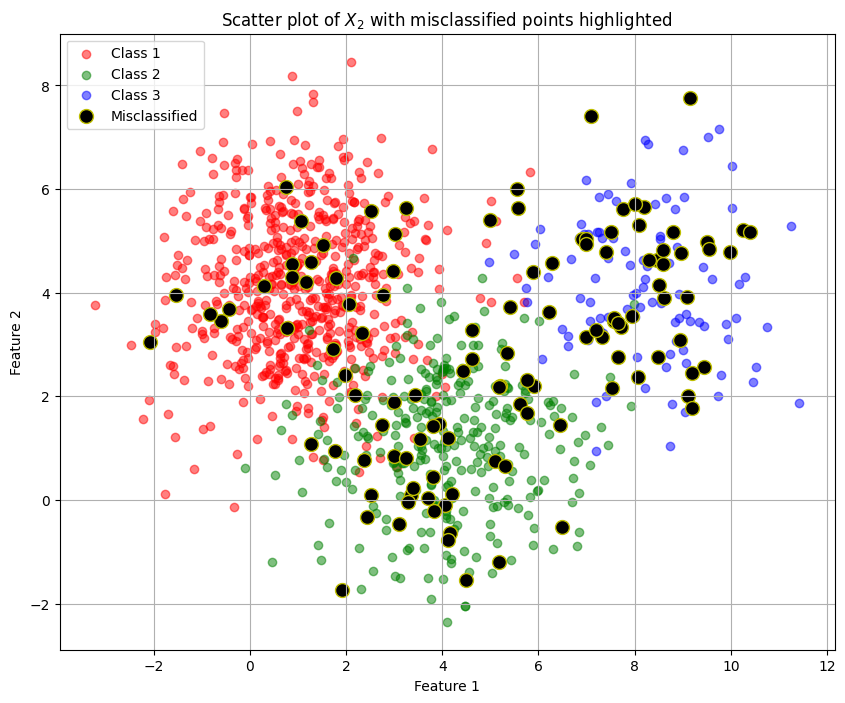

In [42]:
import matplotlib.pyplot as plt

# 使用最佳h值进行分类
predicted_labels_X2 = np.array([classify_map_kde(x, datasets_X2, optimal_h_X2_map, prior_X2) for x in X2])

# 找出分类错误的点
misclassified_indices_X2 = np.where(predicted_labels_X2 != labels_X2)[0]

# 绘制散点图
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b']

# 绘制正确分类的点
for i, dataset in enumerate(datasets_X2, 1):
    plt.scatter(dataset[:, 0], dataset[:, 1], c=colors[i-1], label=f'Class {i}', alpha=0.5)

# 绘制分类错误的点
plt.scatter(X1[misclassified_indices_X2, 0], X1[misclassified_indices_X2, 1], c='k', label='Misclassified', s=100, edgecolors='y')

plt.title('Scatter plot of $X_2$ with misclassified points highlighted')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


# 提高要求

在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析 k=1，3，5 时的概率密度估计结果。同样的，我们先考虑相关的背景知识。

## $ k $-近邻概率密度估计

$ k $-近邻概率密度估计是一种非参数方法，用于估计一个随机变量的概率密度函数。这种方法基于数据集中的每个观测点的局部邻域来估计密度。具体来说，它的工作原理如下：

1. 对于数据集中的每个观测点 $ x $，找到与 $ x $ 最近的 $ k $ 个观测点。
2. 使用这 $ k $ 个观测点的邻域（即其中最远的观测点到 $ x $ 的距离）来估计 $ x $ 处的密度。

这个方法的直观解释是，如果在某个区域内有很多观测点，那么该区域的密度就较高；反之，如果观测点稀疏，则密度较低。

$ k $-近邻概率密度的估计可以表示为：

$$
\hat{f}(x) = \frac{k}{n \times V}
$$

其中：
- $ \hat{f}(x) $ 是 $ x $ 处的密度估计。
- $ k $ 是选择的邻居数量。
- $ n $ 是数据集中的总观测点数。
- $ V $ 是包含 $ k $ 个最近邻居的体积（对于一维数据，它是长度；对于二维数据，它是面积；对于三维数据，它是体积，依此类推）。

这种方法的一个关键参数是 $ k $ 的选择，它决定了考虑的邻域大小。$ k $ 值的选择会影响密度估计的平滑程度：较大的 $ k $ 值会导致更平滑的估计，而较小的 $ k $ 值会导致更崎岖的估计。

总的来说，$ k $-近邻概率密度估计为我们提供了一种直观且简单的方法来估计数据的概率密度，特别是当参数方法不适用或不提供满意结果时。其完全将概率密度概念化，只考虑邻域内观测点的个数来判断当前的概率密度。

In [39]:
def average_k_nearest_density(X, k):
    total_density = sum(k_nearest_density_estimate(x, X, k) for x in X)
    return total_density / len(X)

In [41]:
def k_nearest_density_estimate(x, X, k):
    distances = np.linalg.norm(X - x, axis=1)

    sorted_distances = np.sort(distances)
    kth_distance = sorted_distances[k] if k == 1 else sorted_distances[k-1]

    V = (np.pi * kth_distance**2)

    N = len(X)
    density = k / (N * V)

    return density

k_values=[1,3,5]

avg_densities_X1 = [average_k_nearest_density(X1, k) for k in k_values]
avg_densities_X2 = [average_k_nearest_density(X2, k) for k in k_values]

avg_densities_X1, avg_densities_X2


([0.080557601382865, 0.04447581177905573, 0.02404174723630231],
 [0.2365697815726983, 0.05562235062814482, 0.0304712532239756])


对于 $ X_1 $ 数据集：
- 当 $ k = 1 $ 时，平均密度为 0.0806
- 当 $ k = 3 $ 时，平均密度为 0.0445
- 当 $ k = 5 $ 时，平均密度为 0.0240

对于 $ X_2 $ 数据集：
- 当 $ k = 1 $ 时，平均密度为 0.2366
- 当 $ k = 3 $ 时，平均密度为 0.0556
- 当 $ k = 5 $ 时，平均密度为 0.0305

从这些结果中，我们可以得出以下观察和结论：

1. **随着 $ k $ 值的增加，平均密度估计减小**：这是预期的，因为当我们考虑更多的近邻时，我们的超球体的半径（即第 k 个近邻的距离）会增加，导致体积增加，因此密度估计会减小。

2. **$ X_2 $ 的密度估计高于 $ X_1 $**：尤其在 $ k = 1 $ 时，$ X_2 $ 的估计值明显高于 $ X_1 $。这可能是因为 $ X_2 $ 数据集中的点更为集中，因此它们的近邻距离较小，导致密度估计较高。

3. **数据分布的特性**：$ X_2 $ 数据集具有更高的先验概率的类别（$ p(w_1) = 0.6 $），因此它可能包含更多的集中数据点。这解释了为什么 $ X_2 $ 的密度估计高于 $ X_1 $，尤其是当 $ k $ 值较小时。

4. **k 的选择**：选择较小的 $ k $ 值会使估计受到噪声的影响，而较大的 $ k $ 值可能会平滑真实的分布特性。从结果中可以看出，对于这两个数据集，当 $ k $ 增加时，平均密度逐渐接近，这意味着估计变得更加平滑。
